In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # the more advanced python visualization library

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

    # For Classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

    # For Classification
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Date time
from datetime import datetime

# For distrance calculations between long and lat intersections
from haversine import haversine

sns.set_style('whitegrid')

# apply style to all the charts
sns.set_style('whitegrid')

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Loading clean Dataset

In [2]:
# Load the data
df = pd.read_csv('declarations-exterminations-punaises-de-lit-1.csv')

#### Verify Datatype and make modifications 

In [3]:
# print(df.dtypes)

In [4]:
# Convert 'DATE_INSP_VISPRE', 'DATE_DEBUTTRAIT', and 'DATE_FINTRAIT'

# Ref.:https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
df['DATE_DECLARATION'] = pd.to_datetime(df['DATE_DECLARATION'])
df['DATE_PRIOR_INSP'] = pd.to_datetime(df['DATE_PRIOR_INSP'])
df['DATE_FIRST_EXT'] = pd.to_datetime(df['DATE_FIRST_EXT'])
df['DATE_LAST_EXT'] = pd.to_datetime(df['DATE_LAST_EXT'])

print(df.dtypes)

NO_DECLARATION               int64
DATE_DECLARATION    datetime64[ns]
DATE_PRIOR_INSP     datetime64[ns]
EXT_FREQ                   float64
DATE_FIRST_EXT      datetime64[ns]
DATE_LAST_EXT       datetime64[ns]
HOOD_NUM                    object
HOOD_NAME                   object
BORO_NAME                   object
MTM8_X                     float64
MTM8_Y                     float64
LONGITUDE                  float64
LATITUDE                   float64
LONG_LAT                    object
MTM_X_Y                     object
DEC_MONTH                    int64
DEC_ISSUE                    int64
DATE_DIFF                  float64
dtype: object


#### Dataframe summary

In [5]:
print('Bed bug extermination declarations')
print('')
print('==================COLUMNS==================')
print(df.columns)
print('')
print('==================HEAD==================')
print(df.head())
print('')
print('==================TAIL==================')
print(df.tail())
print('')
print('==================DESCRIBE==================')
print(df.describe())

Bed bug extermination declarations

==================COLUMNS==================
Index(['NO_DECLARATION', 'DATE_DECLARATION', 'DATE_PRIOR_INSP', 'EXT_FREQ',
       'DATE_FIRST_EXT', 'DATE_LAST_EXT', 'HOOD_NUM', 'HOOD_NAME', 'BORO_NAME',
       'MTM8_X', 'MTM8_Y', 'LONGITUDE', 'LATITUDE', 'LONG_LAT', 'MTM_X_Y',
       'DEC_MONTH', 'DEC_ISSUE', 'DATE_DIFF'],
      dtype='object')

==================HEAD==================
   NO_DECLARATION DATE_DECLARATION DATE_PRIOR_INSP  EXT_FREQ DATE_FIRST_EXT  \
0            4254       2012-10-28      2012-09-21      1.00     2012-09-21   
1             830       2011-09-16      2011-07-13      1.00     2011-07-27   
2            1380       2011-11-08      2011-11-02      1.00     2011-11-07   
3             455       2011-08-10      2011-08-09      1.00     2011-08-09   
4            1243       2011-10-26      2011-09-16      1.00     2011-10-05   

  DATE_LAST_EXT HOOD_NUM      HOOD_NAME                            BORO_NAME  \
0    2012-09-21       2

In [6]:
print("df shape:"+str(df.shape) )

df shape:(31241, 18)


In [7]:
df['NO_DECLARATION'].dtype

dtype('int64')

# Feature Engineering

#### Calculate distances between intersections

In [ ]:
print('==================TOP_10_BORO==================')
((df.groupby(['BORO_NAME'])
       .agg({'EXT_FREQ': sum, 'NO_DECLARATION':'count'}))
       .sort_values(by = ['EXT_FREQ','NO_DECLARATION'],ascending=False)
       .rename(columns={'EXT_FREQ':'EXT_QT','NO_DECLARATION':'DECL_QT'})
       .head(10))
print('')
print('==================TOP_10_INTERSECTIONS_BASED_ON_EXT_FREQ_AND_ON_DECLARATIONS==================')
((df.groupby(['LONG_LAT','HOOD_NAME','BORO_NAME'])
       .agg({'EXT_FREQ': sum, 'NO_DECLARATION':'count'}))
       .sort_values(by = ['EXT_FREQ','NO_DECLARATION'],ascending=False)
       .rename(columns={'EXT_FREQ':'EXT_QT','NO_DECLARATION':'DECL_QT'})
       .head(10))

Top five Boroughs are Rosemont–La Petite-Patrie, Mercier–Hochelaga-Maisonneuve, Villeray–Saint-Michel–Parc-Extension, Le Plateau-Mont-Royal, and Ville-Marie. 

Top ten intersections are Saint-Léonard, Saint-Laurent, Côte-des-Neiges–Notre-Dame-de-Grâce, Ahuntsic-Cartierville, Rivière-des-Prairies–Pointe-aux-Trembles, Villeray–Saint-Michel–Parc-Extension, Le Plateau-Mont-Royal (2), Mercier–Hochelaga-Maisonneuve, and Ville-Marie, based on the extermination and declaration quantities.

While these to top intersections can individually be considered as epicenters, the top intersection in the Plateau-Mont-Royal is chosen as reference for this analysis, where the coordinates are -73.585636_45.527404 (LONG_LAT).

In [ ]:
# Inspication for epicenter calculation:
# https://towardsdatascience.com/transforming-categorical-data-for-usability-in-machine-learning-predictions-90459c3fc967?gi=2253c23cb822

# Ref. : https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1    
    
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2    
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6367 * c
    return km

In [ ]:
#Epicenter coordinates
plat_lat = [45.527404] # df['LONG_LAT'== -73.585636_45.527404]
plat_lon = [-73.585636]

# Create distance column in dataframe, which returns km values
df['Dist'] = haversine_np(
    df['LONGITUDE'],df['LATITUDE'], plat_lon,plat_lat)

df['Dist'].head()

#### Convert most columns to Integer

In [8]:
# Ref. : https://stackoverflow.com/questions/43956335/convert-float64-column-to-int64-in-pandas
# df['DATE_DIFF'] = df['DATE_DIFF'].astype(np.int64)
# df['EXT_FREQ'] = df['EXT_FREQ'].astype(np.int64)

# # Ref.: https://stackoverflow.com/questions/50863691/pandas-convert-date-object-to-int\
# # df['DATE_DECLARATION'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_PRIOR_INSP'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_FIRST_EXT'].dt.strftime("%Y%m%d").astype(int)
# # df['DATE_LAST_EXT'].dt.strftime("%Y%m%d").astype(int)

# # Ref.: https://thispointer.com/python-how-to-convert-datetime-object-to-string-using-datetime-strftime/
# # df['DATE_DECLARATION'] = df['DATE_DECLARATION'].strftime("%Y-%b-%d")

# # Ref.: https://stackoverflow.com/questions/47562634/converting-numpy-datetime64-to-long-integer-and-back
# np.datetime64(np.datetime64(df['DATE_DECLARATION']).astype(long), 'ns')

# df.dtypes

#### Create Month and Year Columns 

In [9]:
#We have this for month and year:

df['DEC_D'] = (pd.DatetimeIndex(df['DATE_DECLARATION']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_DECLARATION']).month).map(str)
    
df['PRIOR_D'] = (pd.DatetimeIndex(df['DATE_PRIOR_INSP']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_PRIOR_INSP']).month).map(str)

df['FIRST_D'] = (pd.DatetimeIndex(df['DATE_FIRST_EXT']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_FIRST_EXT']).month).map(str)

df['LAST_D'] = (pd.DatetimeIndex(df['DATE_LAST_EXT']).year).map(str) + (
    pd.DatetimeIndex(df['DATE_LAST_EXT']).month).map(str)

# Create difference between LAST and FIRST Extermination
df['D_DIFF_B'] = round( (df['DATE_LAST_EXT'] - df['DATE_FIRST_EXT'] ) 
                                / np.timedelta64(1,'D') )
    # ['D_DIFF_B'] = ['DATE_LAST_EXT'] - ['DATE_FIRST_EXT']

# Create difference between LAST and FIRST Extermination
df['D_DIFF_C'] = round( (df['DATE_FIRST_EXT'] - df['DATE_PRIOR_INSP'] ) 
                                / np.timedelta64(1,'D') )
    # ['D_DIFF_C'] = ['DATE_FIRST_EXT'] - ['DATE_PRIOR_INSP']

    
# rename column
df['D_DIFF_A'] = df['DATE_DIFF'].copy() # ['D_DIFF_A'] = ['DATE_DECLARATION'] - ['DATE_PRIOR_INSP']

#### Remote unused columns

In [10]:
del df['DEC_MONTH']

del df['HOOD_NUM']
del df['HOOD_NAME']
del df['BORO_NAME']
del df['MTM8_X']
del df['MTM8_Y']
del df['MTM_X_Y']
del df['DEC_ISSUE']

del df['DATE_DIFF']

del df['NO_DECLARATION']
df.dtypes

DATE_DECLARATION    datetime64[ns]
DATE_PRIOR_INSP     datetime64[ns]
EXT_FREQ                   float64
DATE_FIRST_EXT      datetime64[ns]
DATE_LAST_EXT       datetime64[ns]
LONGITUDE                  float64
LATITUDE                   float64
LONG_LAT                    object
DEC_D                       object
PRIOR_D                     object
FIRST_D                     object
LAST_D                      object
D_DIFF_B                   float64
D_DIFF_C                   float64
D_DIFF_A                   float64
dtype: object

### Missing values 

In [11]:
df.isnull().sum()

DATE_DECLARATION    0
DATE_PRIOR_INSP     0
EXT_FREQ            0
DATE_FIRST_EXT      0
DATE_LAST_EXT       0
LONGITUDE           0
LATITUDE            0
LONG_LAT            0
DEC_D               0
PRIOR_D             0
FIRST_D             0
LAST_D              0
D_DIFF_B            0
D_DIFF_C            0
D_DIFF_A            0
dtype: int64

### Additing intersections as columns

In [12]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS

# intersection to numerical columns
df_inter = pd.get_dummies(df['LONG_LAT'])
df_model = pd.concat([df, df_inter], axis=1).fillna(0.0)

print(list(df_inter.columns))
print('')


['-73.485599_45.698515', '-73.487241_45.695382', '-73.487936_45.649078', '-73.489228_45.693533', '-73.489451_45.689027', '-73.489574_45.644719', '-73.48965600000001_45.688243', '-73.49010899999999_45.653622', '-73.490427_45.639412', '-73.490471_45.651309000000005', '-73.49077199999999_45.649502000000005', '-73.491029_45.63825', '-73.491455_45.675867', '-73.491575_45.694154', '-73.492104_45.650409', '-73.492193_45.645915', '-73.492277_45.641759', '-73.492308_45.6918', '-73.492402_45.635714', '-73.492599_45.648424', '-73.49268199999999_45.640356', '-73.492705_45.635064', '-73.492806_45.649871999999995', '-73.49305600000001_45.694758', '-73.493218_45.634094', '-73.493376_45.673096', '-73.493579_45.672385', '-73.493804_45.638015', '-73.494232_45.632907', '-73.494577_45.654878000000004', '-73.494659_45.636764', '-73.494709_45.692941999999995', '-73.49474599999999_45.651274', '-73.49503_45.66381', '-73.495091_45.658223', '-73.49525600000001_45.643611', '-73.495408_45.666224', '-73.495627_45.

In [13]:
print('================df_model.columns================')
print(list(df_model.columns))

================df_model.columns================
['DATE_DECLARATION', 'DATE_PRIOR_INSP', 'EXT_FREQ', 'DATE_FIRST_EXT', 'DATE_LAST_EXT', 'LONGITUDE', 'LATITUDE', 'LONG_LAT', 'DEC_D', 'PRIOR_D', 'FIRST_D', 'LAST_D', 'D_DIFF_B', 'D_DIFF_C', 'D_DIFF_A', '-73.485599_45.698515', '-73.487241_45.695382', '-73.487936_45.649078', '-73.489228_45.693533', '-73.489451_45.689027', '-73.489574_45.644719', '-73.48965600000001_45.688243', '-73.49010899999999_45.653622', '-73.490427_45.639412', '-73.490471_45.651309000000005', '-73.49077199999999_45.649502000000005', '-73.491029_45.63825', '-73.491455_45.675867', '-73.491575_45.694154', '-73.492104_45.650409', '-73.492193_45.645915', '-73.492277_45.641759', '-73.492308_45.6918', '-73.492402_45.635714', '-73.492599_45.648424', '-73.49268199999999_45.640356', '-73.492705_45.635064', '-73.492806_45.649871999999995', '-73.49305600000001_45.694758', '-73.493218_45.634094', '-73.493376_45.673096', '-73.493579_45.672385', '-73.493804_45.638015', '-73.494232_45

In [14]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS

# select the columns
    # X input for model
    
X_columns = ['EXT_FREQ', 'LAST_D', 'D_DIFF_C', 'D_DIFF_A','DEC_D','PRIOR_D','FIRST_D'
            ] + list(df_inter.columns) # +'Dist'
    

# measured output Y
y_column = ['D_DIFF_B']
    # Ref.: http://donnees.ville.montreal.qc.ca/dataset/declarations-exterminations-punaises-de-lit/resource/6173de60-c2da-4d63-bc75-0607cb8dcb74
    # Recall DATE_FINTRAIT [now DATE_LAST_EXT] : Date for the end of the last extermination associated to a declaration

print(X_columns)

['EXT_FREQ', 'LAST_D', 'D_DIFF_C', 'D_DIFF_A', 'DEC_D', 'PRIOR_D', 'FIRST_D', '-73.485599_45.698515', '-73.487241_45.695382', '-73.487936_45.649078', '-73.489228_45.693533', '-73.489451_45.689027', '-73.489574_45.644719', '-73.48965600000001_45.688243', '-73.49010899999999_45.653622', '-73.490427_45.639412', '-73.490471_45.651309000000005', '-73.49077199999999_45.649502000000005', '-73.491029_45.63825', '-73.491455_45.675867', '-73.491575_45.694154', '-73.492104_45.650409', '-73.492193_45.645915', '-73.492277_45.641759', '-73.492308_45.6918', '-73.492402_45.635714', '-73.492599_45.648424', '-73.49268199999999_45.640356', '-73.492705_45.635064', '-73.492806_45.649871999999995', '-73.49305600000001_45.694758', '-73.493218_45.634094', '-73.493376_45.673096', '-73.493579_45.672385', '-73.493804_45.638015', '-73.494232_45.632907', '-73.494577_45.654878000000004', '-73.494659_45.636764', '-73.494709_45.692941999999995', '-73.49474599999999_45.651274', '-73.49503_45.66381', '-73.495091_45.658

Using regression, use a model in order to determine the features that help determine lead time from the first extermination, in order to determine the recommended waiting duration prior to entering a dwelwing at an intersection where an extermination previously occured. Factors such as the radius from the intersection are not considered in the model.

An alternative regression would entail in determining the number of declarations, although the number of exterminations is capped at four for each declaration. This alternative is not considered in this model. A classification model can be created to determine whether the extermination occured successfully or not with False Positives and True Negatives, as an indicate that an inspection is needed to verify a future reoccurence.

# Model Training

In [15]:
# threshold = 0.8 
# 80% for train, 20% for test

threshold = 0.8

X = df_model[X_columns]
y = df_model[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

print('==============X_train==============') # X_train
print(X_train.shape)
print(X_train.dtypes)
print('')
print('==============y_train==============') # y_train
print(y_train.shape) 
print(y_train.dtypes)
print('')
print('==============X_test==============') # X_test
print(X_test.shape)
print(X_test.dtypes)
print('')
print('==============y_test==============') # y_test
print(y_test.shape) 
print(y_test.dtypes) 

==============X_train==============
(24992, 4734)
EXT_FREQ                                 float64
LAST_D                                    object
D_DIFF_C                                 float64
D_DIFF_A                                 float64
DEC_D                                     object
PRIOR_D                                   object
FIRST_D                                   object
-73.485599_45.698515                       uint8
-73.487241_45.695382                       uint8
-73.487936_45.649078                       uint8
-73.489228_45.693533                       uint8
-73.489451_45.689027                       uint8
-73.489574_45.644719                       uint8
-73.48965600000001_45.688243               uint8
-73.49010899999999_45.653622               uint8
-73.490427_45.639412                       uint8
-73.490471_45.651309000000005              uint8
-73.49077199999999_45.649502000000005      uint8
-73.491029_45.63825                        uint8
-73.491455_45.67586

### Linear Regression

MAE 225833.35


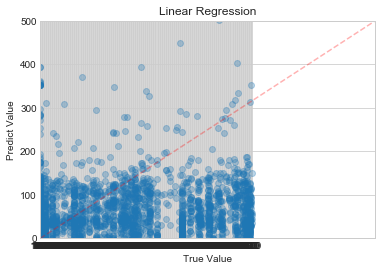

RMAE 3276713.41


In [16]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae, 2))

plt.scatter(y_test, y_pred, alpha=0.3)

plt.plot(range(0,500, 1), range(0,500, 1), '--r', alpha=0.3, label='Line1')

plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.show()

#calculate the RMSE
RMAE = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMAE', round(RMAE, 2))

### KNN

In [17]:
model = KNeighborsRegressor(10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae, 2))

MAE 17.42


### Decision Tree

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE', round(mae, 2))

MAE 17.01


# Experiments

Linear Regression
MAE 225833.34669283917
RMSE 3276713.4083753754


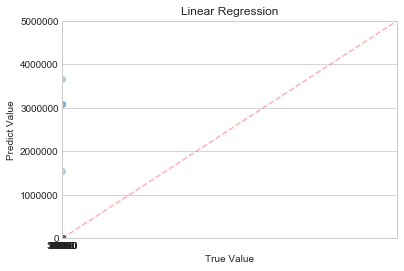


KNN 5
MAE 15.791166586653864
RMSE 79.21658802833542


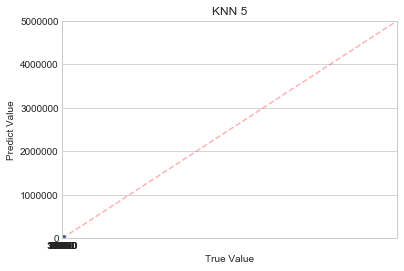


KNN 2
MAE 14.194031044967195
RMSE 75.55691004444844


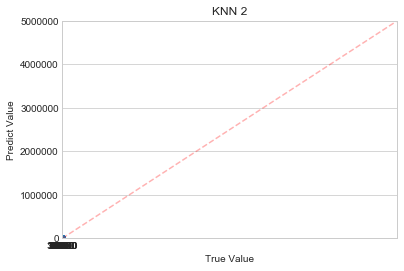


Decision Tree
MAE 16.786365818530964
RMSE 97.58118965339511


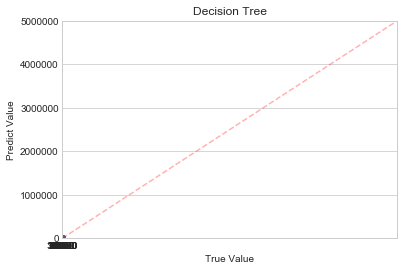

C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest 10
MAE 15.046204116468157
RMSE 71.33946030868584


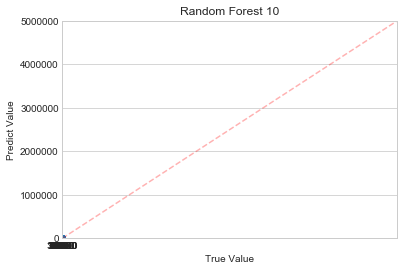

C:\Users\outpost\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [ ]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS/blob/master/week5/regression-house-sklearn-ext-class-version.ipynb

def model_training(model_name, model, X_train, y_train):
    model.fit(X_train, y_train)
    return model
    
def model_prediction(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred

def model_evaluation(model_name, y_test, y_pred):
    print(model_name)
    print('MAE', mean_absolute_error(y_test, y_pred))
    print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot(range(0,5000000, 100), range(0,5000000, 100), '--r', alpha=0.3, label='Line1')
    plt.title(model_name)
    plt.xlabel('True Value')
    plt.ylabel('Predict Value')
    plt.xlim([0, 5000000])
    plt.ylim([0, 5000000])
    plt.show()
    print('')

def run_experiment(model_name, model, X_train, y_train, X_test):
    train_model = model_training(model_name, model, X_train, y_train)
    predictions = model_prediction(train_model, X_test)
    model_evaluation(model_name, y_test, predictions)
    
run_experiment('Linear Regression', LinearRegression(), X_train, y_train, X_test)
run_experiment('KNN 5', KNeighborsRegressor(5), X_train, y_train, X_test)
run_experiment('KNN 2', KNeighborsRegressor(2), X_train, y_train, X_test)
run_experiment('Decision Tree', DecisionTreeRegressor(), X_train, y_train, X_test)
run_experiment('Random Forest 10', RandomForestRegressor(10), X_train, y_train, X_test)
run_experiment('Random Forest 100', RandomForestRegressor(100), X_train, y_train, X_test)

# Error Analysis

In [ ]:
# Ref.: https://github.com/arybressane/CEBD1260-BIG-DATA-ANALYTICS/blob/master/week5/regression-house-sklearn-ext-class-version.ipynb

model = RandomForestRegressor(100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
#for i in range(len(X_test.columns)):
fi = []
for i, col in enumerate(X_test.columns):
    fi.append([col, model.feature_importances_[i]])
pd.DataFrame(fi).sort_values(1, ascending=False)

In [ ]:
df_test = pd.DataFrame(X_test).copy()
df_test['price'] = y_test
df_test['prediction'] = y_pred
df_test['abs_error'] = abs(df_test['price']-df_test['prediction'])
df_test.sort_values(by='abs_error', ascending=False).round()

In [ ]:
plt.hist(df_test['abs_error'], bins=30)
plt.show()

In [ ]:
df_error = df_test[df_test['abs_error']>0]
df_error

In [ ]:
df_error.describe()

In [ ]:
df_error.corr()['abs_error'].dropna().sort_values()

# Cross Validation

In [ ]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100, n_jobs=4)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
]

k = 10
results = {}
for m in models:
     print('MODEL', m[0])
     results[m[0]] = {'mae':[], 'rmse':[]}
     kf = KFold(n_splits=k)
     for train_index, test_index in kf.split(X):
         X_train_k, X_test_k = X.values[train_index], X.values[test_index]
         y_train_k, y_test_k = y.values[train_index], y.values[test_index]
        
         model = m[1]
         model.fit(X_train_k, y_train_k.ravel())
         y_pred = model.predict(X_test_k)
            
         mae = mean_absolute_error(y_test_k, y_pred)
         rmse = np.sqrt(mean_squared_error(y_test_k, y_pred))
            
         results[m[0]]['mae'].append(mae)
         results[m[0]]['rmse'].append(rmse)

In [ ]:
for metric in ['mae', 'rmse']:
     values = []
     labels = []
     for model, result_values in results.items():
         for m, v in result_values.items():
             if m == metric:
                 labels.append(model)
                 values.append(v)
                    
     plt.figure(figsize=(12,6))
     plt.title(metric)
     plt.boxplot(values)
     plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
     plt.show()

# Commentary